In [1]:
import nltk

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import word_tokenize, ngrams
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss
# import xgboost as xgb

eng_stopwords = set(stopwords.words('english'))
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'

In [93]:
train_df = pd.read_csv('/Users/Rishi/Desktop/data_sci_code_challenge/train.csv')
test_df = pd.read_csv('/Users/Rishi/Desktop/data_sci_code_challenge/test.csv')
print(train_df.shape)
print(test_df.shape)

(2142, 6)
(516, 4)


In [94]:
train_df.head()

,Unnamed: 0,description_x,description_y,ticker_x,ticker_y,same_security
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False
3,3,duke energy corp new com new isin #us4 sedol #...,duke energy corp new com new isin #us26441c204...,DUK,DUK,True
4,4,visa inc class a,visa inc.,V,V,True


In [95]:
train_df.rename(columns ={'description_x':'question1','description_y':'question2','same_security':'is_similar'},inplace=True)

In [96]:
train_df.head()

,Unnamed: 0,question1,question2,ticker_x,ticker_y,is_similar
0,0,first trust dow jones internet,first trust dj internet idx,FDN,FDN,True
1,1,schwab intl large company index etf,schwab strategic tr fundamental intl large co ...,FNDF,FNDF,True
2,2,vanguard small cap index adm,vanguard small-cap index fund inst,VSMAX,VSCIX,False
3,3,duke energy corp new com new isin #us4 sedol #...,duke energy corp new com new isin #us26441c204...,DUK,DUK,True
4,4,visa inc class a,visa inc.,V,V,True


In [97]:
test_df.head()

,test_id,description_x,description_y,same_security
0,0,semtech corp,semtech corporation,NaN
1,1,vanguard mid cap index,vanguard midcap index - a,NaN
2,2,spdr gold trust gold shares,spdr gold trust spdr gold shares,NaN
3,3,vanguard total bond index adm,vanguard total bond market index,NaN
4,4,oakmark international fund class i,oakmark international cl i,NaN


In [98]:
test_df.rename(columns={'description_x':'question1','description_y':'question2','same_security':'is_similar'},inplace=True)

In [99]:
test_df.head()

,test_id,question1,question2,is_similar
0,0,semtech corp,semtech corporation,NaN
1,1,vanguard mid cap index,vanguard midcap index - a,NaN
2,2,spdr gold trust gold shares,spdr gold trust spdr gold shares,NaN
3,3,vanguard total bond index adm,vanguard total bond market index,NaN
4,4,oakmark international fund class i,oakmark international cl i,NaN


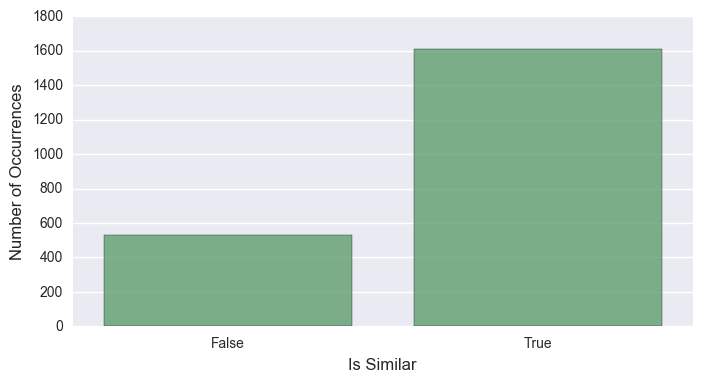

In [100]:
##  Target Exploration
is_sim = train_df['is_similar'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[1])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Is Similar', fontsize=12)
plt.show()

In [101]:
is_sim/is_sim.sum()

True     0.753035
False    0.246965
Name: is_similar, dtype: float64

In [102]:
# Questions Exploration:

# Now we will explore the question fields in the train data. First let us check the number of words distribution in the questions.

In [103]:
all_ques_df = pd.DataFrame(pd.concat([train_df['question1'], train_df['question2']]))
all_ques_df.columns =["questions"]

all_ques_df["num_of_words"] = all_ques_df["questions"].apply(lambda x: len(str(x).split()))

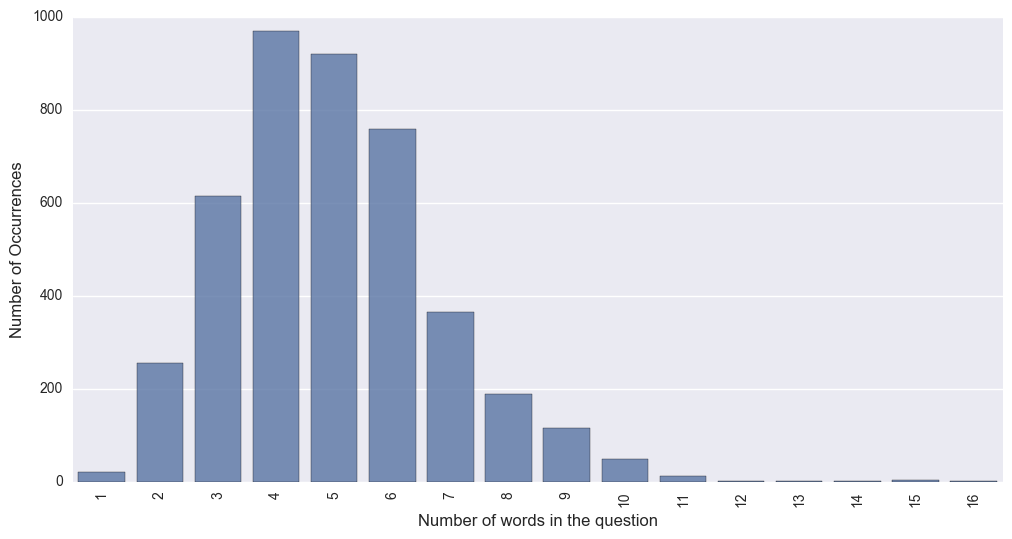

In [104]:
count_str = all_ques_df["num_of_words"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(count_str.index, count_str.values, alpha=0.8, color=color[0])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Number of words in the question', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()


In [105]:
## So the distribution is right skewed with upto 16 words in a question. There are also few questions with 1 or 2 words as well.
# Now let us explore the number of characters distribution as well.

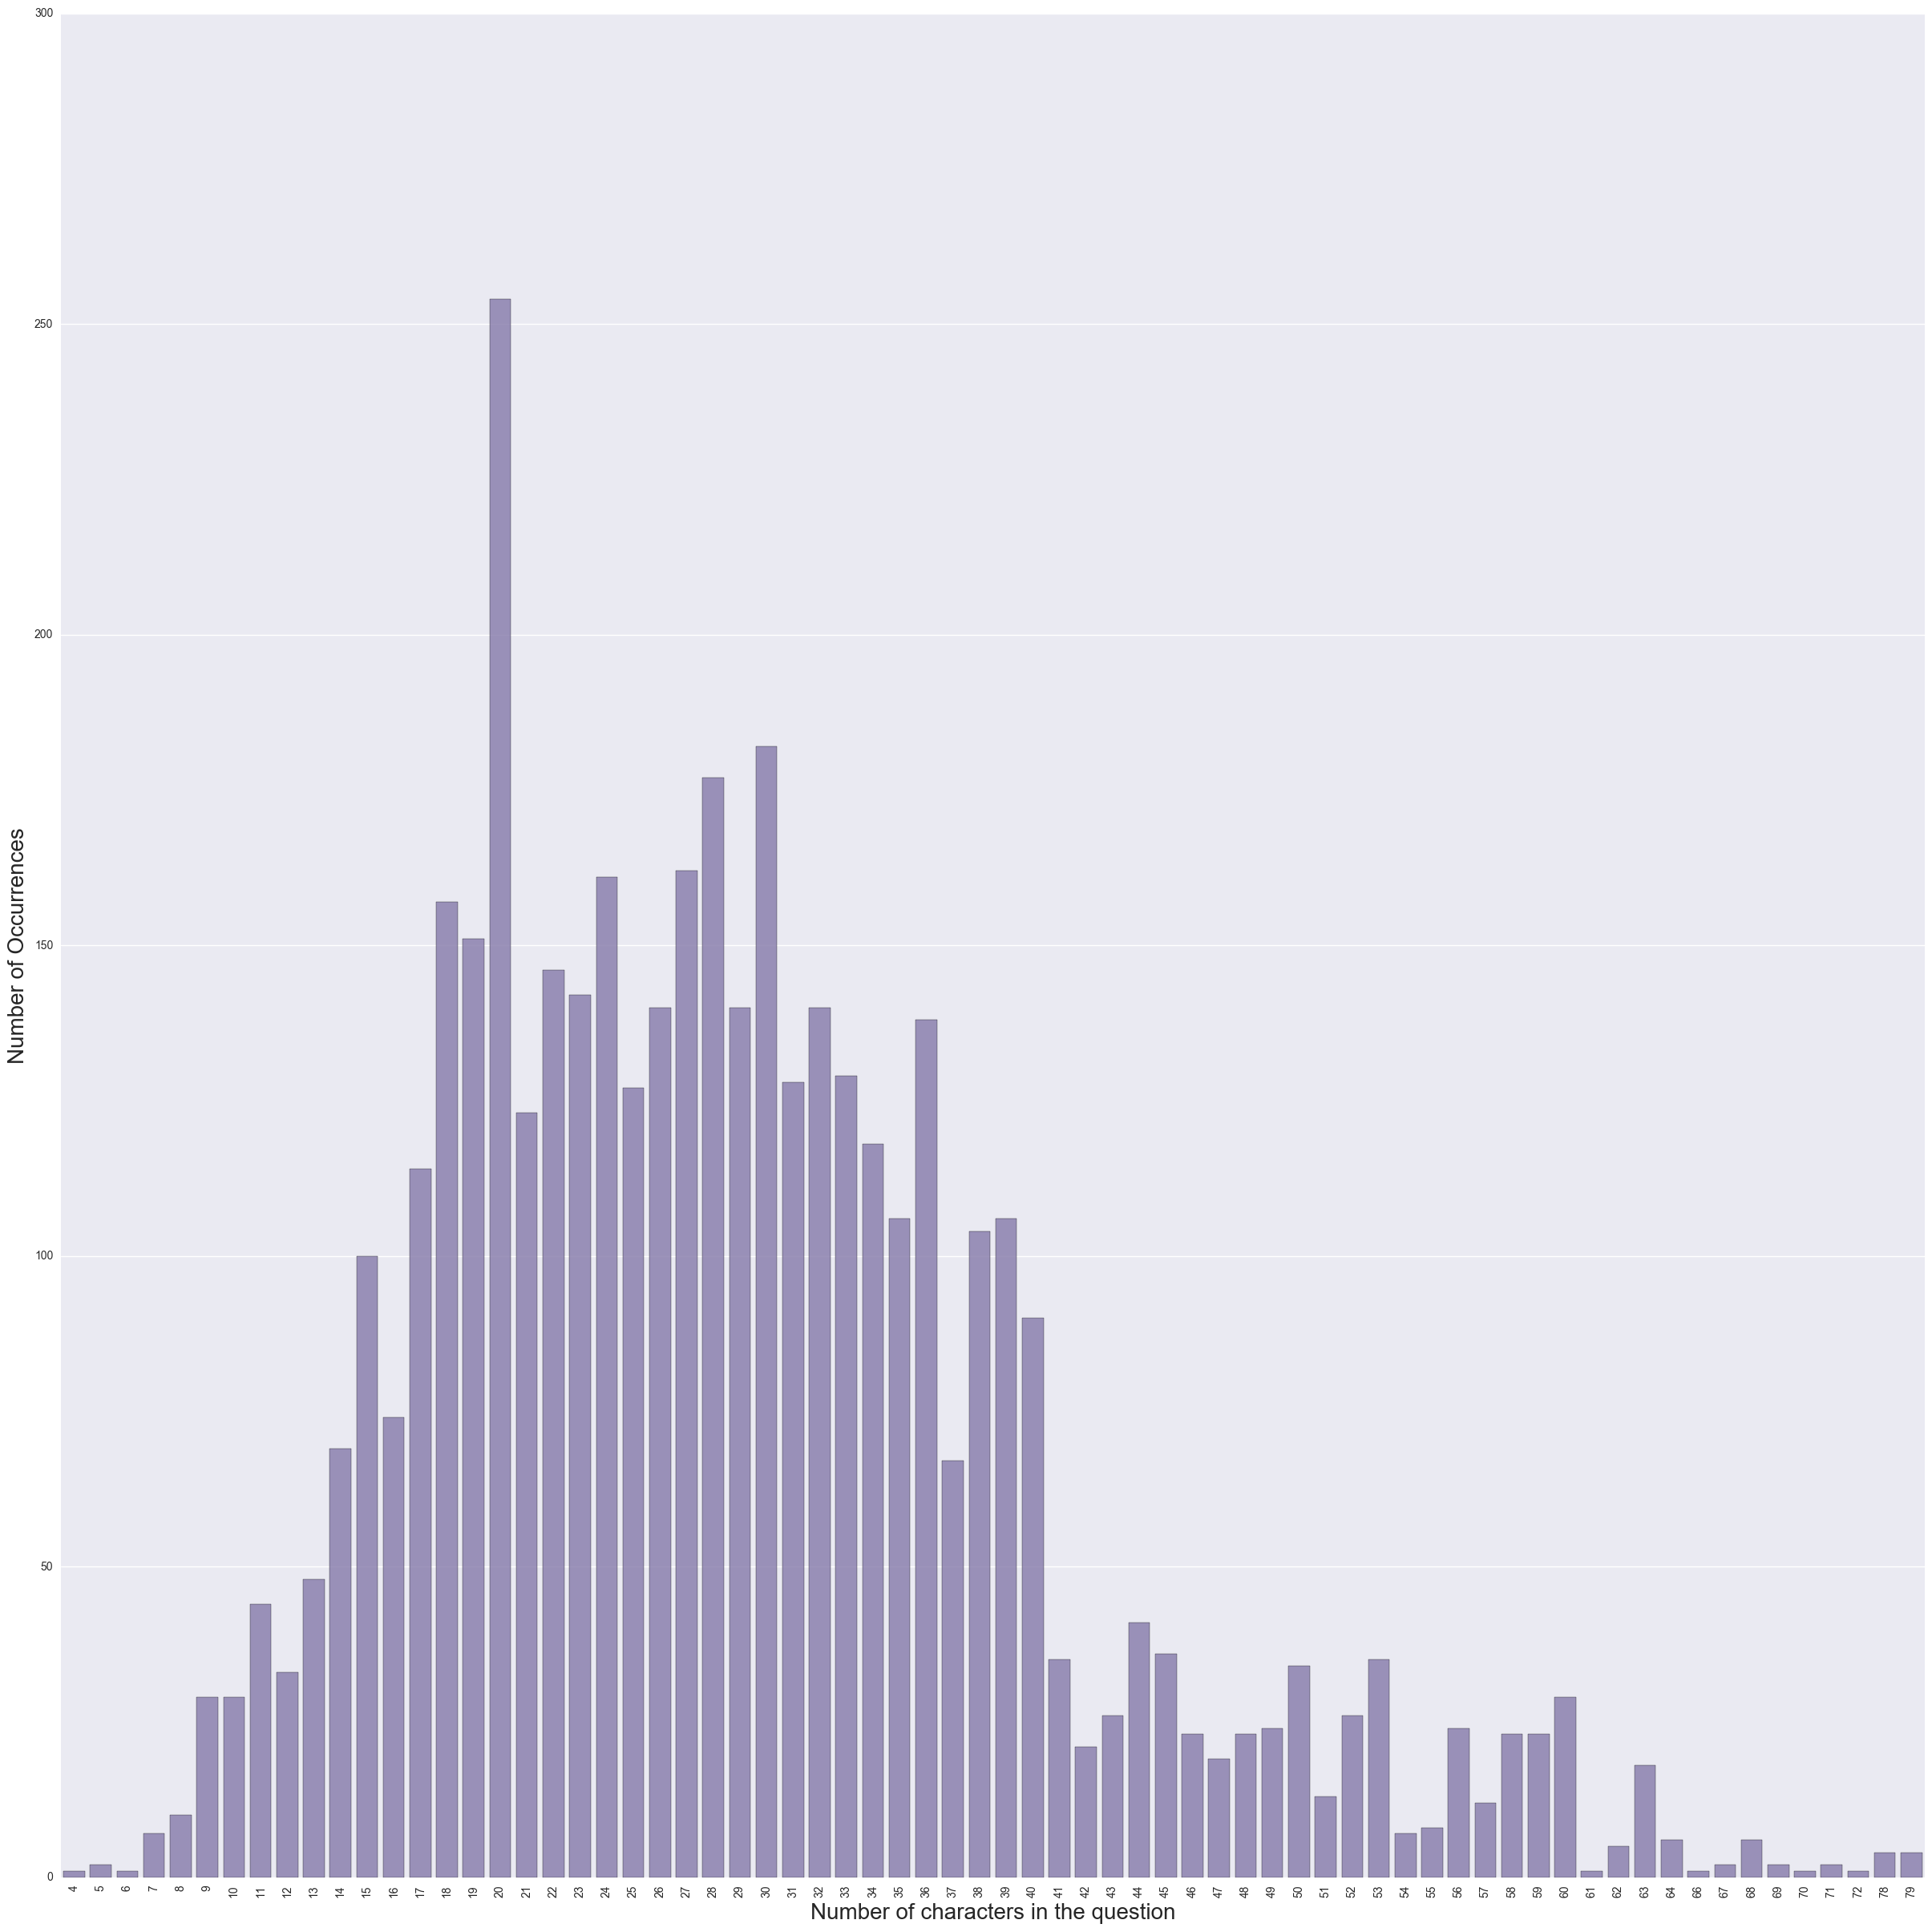

In [106]:
all_ques_df["num_of_chars"] = all_ques_df["questions"].apply(lambda x: len(str(x)))
count_str = all_ques_df["num_of_chars"].value_counts()

plt.figure(figsize=(30,30))
sns.barplot(count_str.index, count_str.values, alpha=0.8, color=color[3])
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Number of characters in the question', fontsize=20)
plt.xticks(rotation='vertical')
plt.show()      

# del all_ques_df                                                         

In [107]:
## Now let us look at the distribution of common unigrams between the given question pairs.
def get_unigrams(que):
    return [word for word in word_tokenize(que.lower()) if word not in eng_stopwords]

## Finding the intersection between two series in pandas and return len.
def get_common_unigrams(row):
    return len( set(row["unigrams_ques1"]).intersection(set(row["unigrams_ques2"])) ) 

def get_common_unigram_ratio(row):
    return float(row["unigrams_common_count"]) / max(len( set(row["unigrams_ques1"]).union(set(row["unigrams_ques2"])) ),1)

train_df["unigrams_ques1"] = train_df['question1'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_ques2"] = train_df['question2'].apply(lambda x: get_unigrams(str(x)))
train_df["unigrams_common_count"] = train_df.apply(lambda row: get_common_unigrams(row), axis=1)
train_df["unigrams_common_ratio"] = train_df.apply(lambda row: get_common_unigram_ratio(row),axis=1)

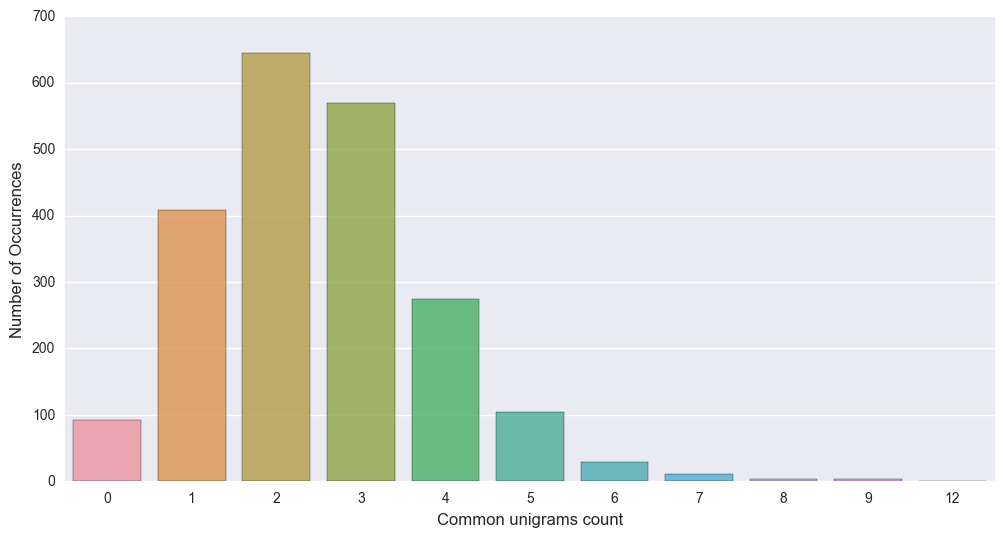

In [108]:
count_str = train_df["unigrams_common_count"].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(count_str.index, count_str.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common unigrams count', fontsize=12)
plt.show()

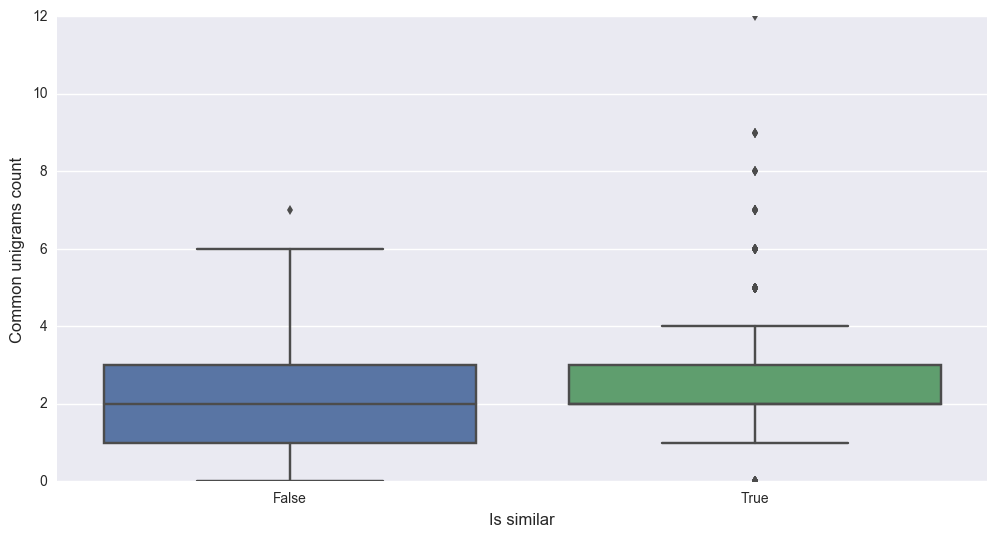

In [109]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_similar", y="unigrams_common_count", data=train_df)
plt.xlabel('Is similar', fontsize=12)
plt.ylabel('Common unigrams count', fontsize=12)
plt.show()

In [110]:
## There is some good difference between 0 and 1 class using the common unigram count variable. Let us look at the same graph using common unigrams ratio.

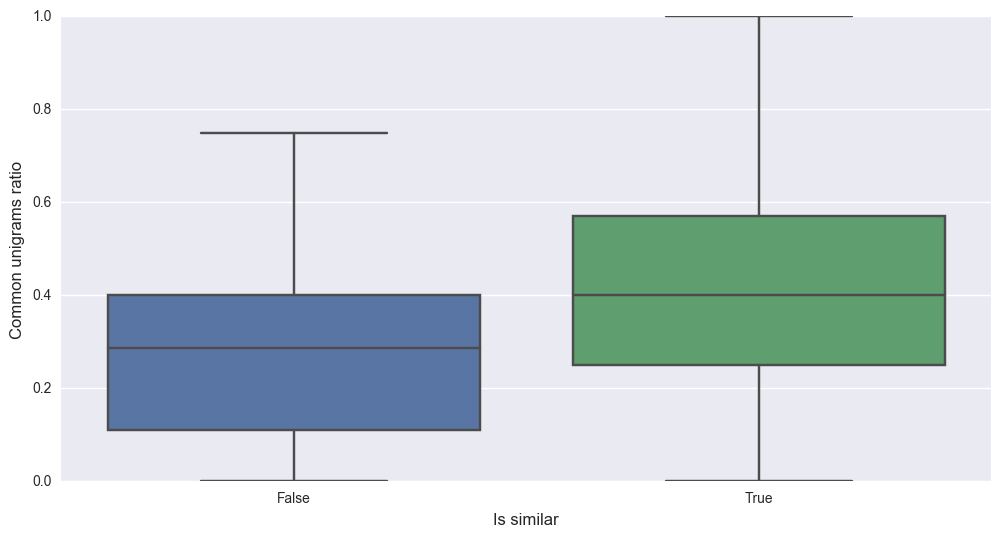

In [111]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_similar", y="unigrams_common_ratio", data=train_df)
plt.xlabel('Is similar', fontsize=12)
plt.ylabel('Common unigrams ratio', fontsize=12)
plt.show()

In [112]:
## BiGrams

In [113]:
def get_bigrams(que):
    return [ i for i in ngrams(que,2)]

def get_common_bigrams(row):
    return len( set(row['bigrams_ques1']).intersection(set(row['bigrams_ques2'])) )

def get_common_bigram_ratio(row):
    return float(row["bigrams_common_count"]) / max(len( set(row["bigrams_ques1"]).union(set(row["bigrams_ques2"])) ),1)

train_df["bigrams_ques1"] = train_df["unigrams_ques1"].apply(lambda x: get_bigrams(x))
train_df["bigrams_ques2"] = train_df["unigrams_ques2"].apply(lambda x: get_bigrams(x))
train_df["bigrams_common_count"] = train_df.apply(lambda row: get_common_bigrams(row), axis=1)
train_df["bigrams_common_ratio"] = train_df.apply(lambda row: get_common_bigram_ratio(row), axis=1)

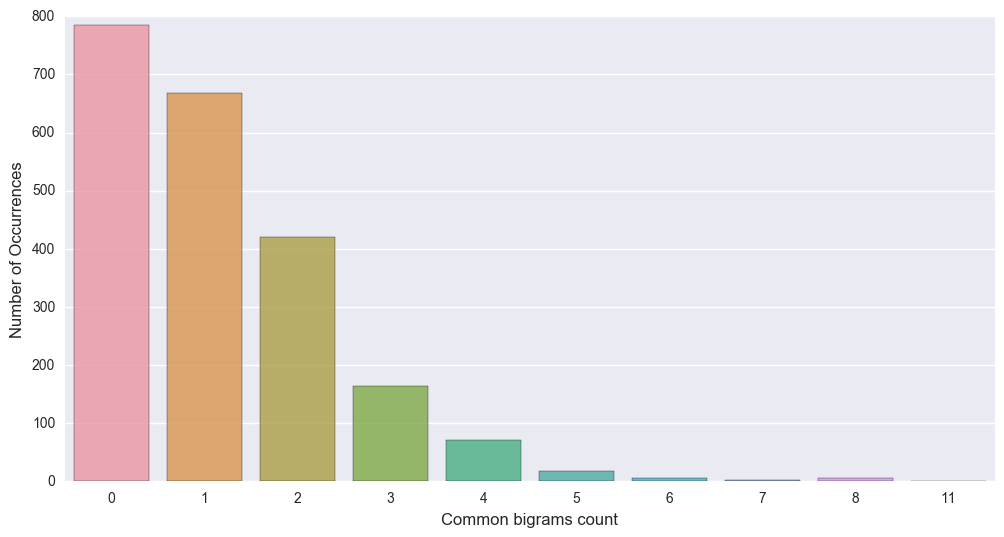

In [114]:
count_str = train_df['bigrams_common_count'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(count_str.index, count_str.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Common bigrams count', fontsize=12)
plt.show()

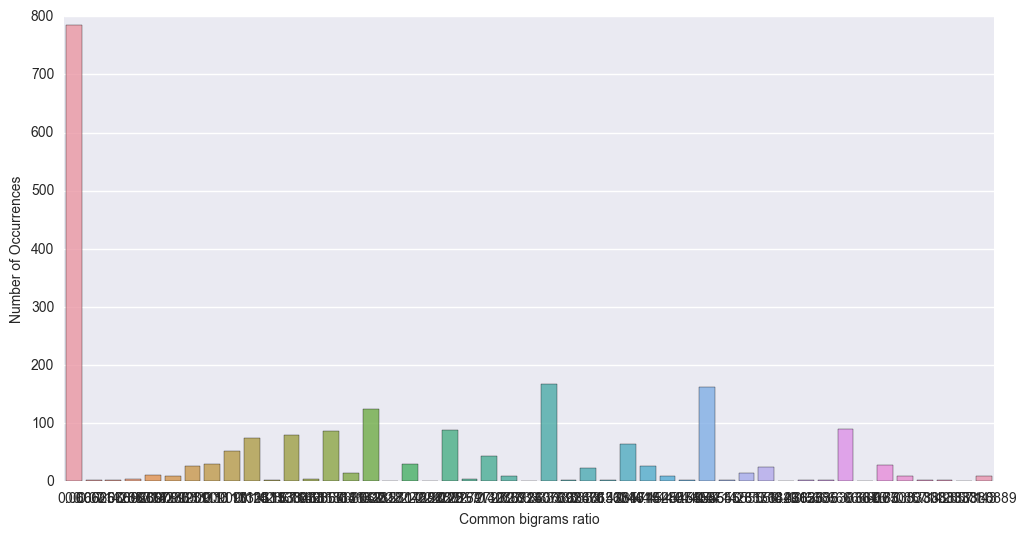

In [115]:
count_str = train_df['bigrams_common_ratio'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(count_str.index, count_str.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('Common bigrams ratio', fontsize=10)
plt.show()

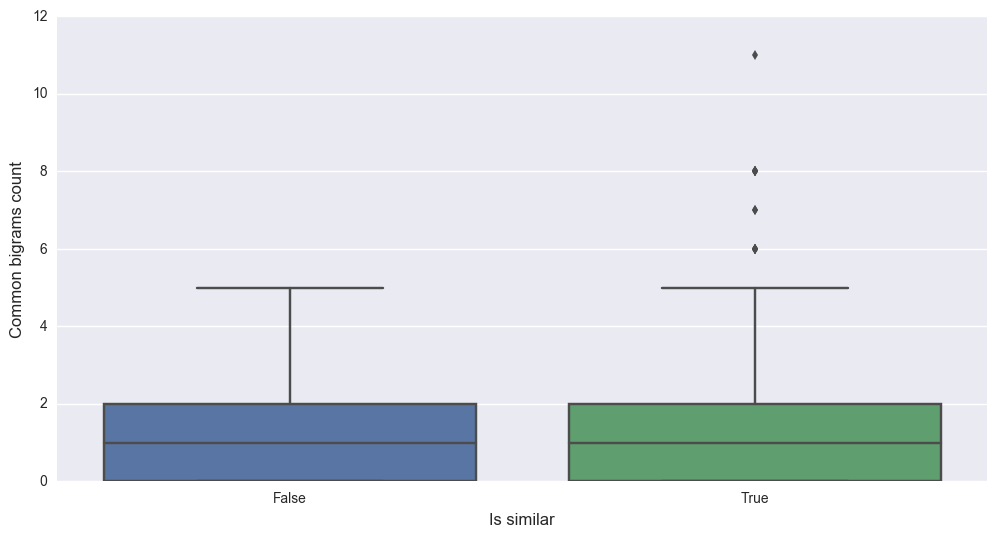

In [116]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_similar", y="bigrams_common_count", data=train_df)
plt.xlabel('Is similar', fontsize=12)
plt.ylabel('Common bigrams count', fontsize=12)
plt.show()

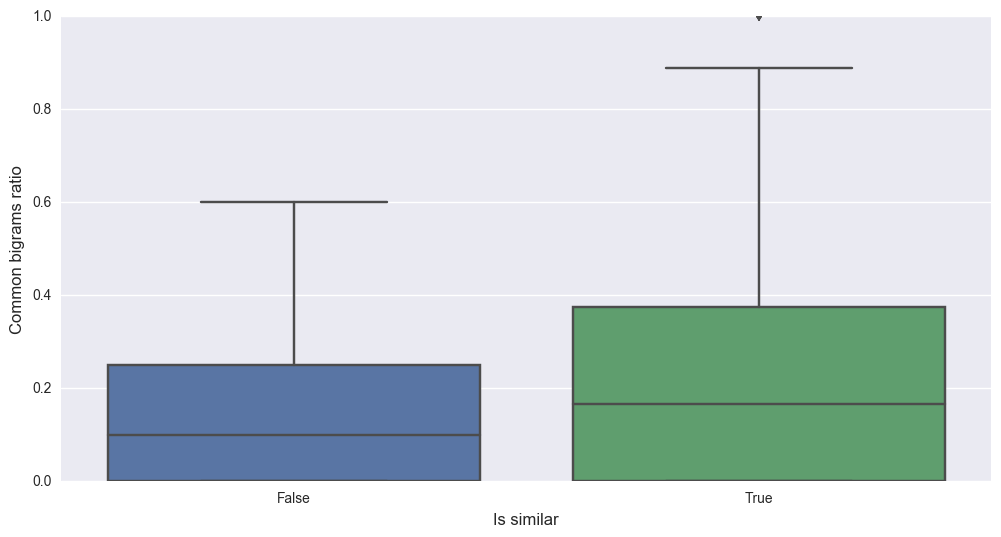

In [117]:
plt.figure(figsize=(12,6))
sns.boxplot(x="is_similar", y="bigrams_common_ratio", data=train_df)
plt.xlabel('Is similar', fontsize=12)
plt.ylabel('Common bigrams ratio', fontsize=12)
plt.show()

In [123]:
def feature_extraction(row):
    que1 = str(row['question1'])
    que2 = str(row['question2'])
    out_list = []
    # get unigram features #
    unigrams_que1 = [word for word in que1.lower().split() if word not in eng_stopwords]
    unigrams_que2 = [word for word in que2.lower().split() if word not in eng_stopwords]
    common_unigrams_len = len(set(unigrams_que1).intersection(set(unigrams_que2)))
    common_unigrams_ratio = float(common_unigrams_len) / max(len(set(unigrams_que1).union(set(unigrams_que2))),1)
    out_list.extend([common_unigrams_len, common_unigrams_ratio])
    
    # get bigram features #
    bigrams_que1 = [i for i in ngrams(unigrams_que1, 2)]
    bigrams_que2 = [i for i in ngrams(unigrams_que2, 2)]
    common_bigrams_len = len(set(bigrams_que1).intersection(set(bigrams_que2)))
    common_bigrams_ratio = float(common_bigrams_len) / max(len(set(bigrams_que1).union(set(bigrams_que2))),1)
    out_list.extend([common_bigrams_len, common_bigrams_ratio])
    
    # get trigram features #
    trigrams_que1 = [i for i in ngrams(unigrams_que1, 3)]
    trigrams_que2 = [i for i in ngrams(unigrams_que2, 3)]
    common_trigrams_len = len(set(trigrams_que1).intersection(set(trigrams_que2)))
    common_trigrams_ratio = float(common_trigrams_len) / max(len(set(trigrams_que1).union(set(trigrams_que2))),1)
    out_list.extend([common_trigrams_len, common_trigrams_ratio])
    return out_list

In [124]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.02
        params["subsample"] = 0.7
        params["min_child_weight"] = 1
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 4
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 300 
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=100, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)
                
        pred_test_y = model.predict(xgtest)

        loss = 1
        if test_y is not None:
                loss = log_loss(test_y, pred_test_y)
                return pred_test_y, loss, model
        else:
            return pred_test_y, loss, modelv

In [125]:
train_X = np.vstack( np.array(train_df.apply(lambda row: feature_extraction(row), axis=1)) ) 
test_X = np.vstack( np.array(test_df.apply(lambda row: feature_extraction(row), axis=1)) )
train_y = np.array(train_df["is_similar"])
test_id = np.array(test_df["test_id"])

In [126]:
train_X_similar = train_X[train_y==1]
train_X_non_similar = train_X[train_y==0]

train_X = np.vstack([train_X_non_similar, train_X_similar, train_X_non_similar, train_X_non_similar])
train_y = np.array([0]*train_X_non_similar.shape[0] + [1]*train_X_similar.shape[0] + [0]*train_X_non_similar.shape[0] + [0]*train_X_non_similar.shape[0])
del train_X_similar
del train_X_non_similar
print("Mean target rate : ",train_y.mean())

Mean target rate :  0.5040625


In [122]:
kf = KFold(n_splits=5, shuffle=True, random_state=2016)
for dev_index, val_index in kf.split(range(train_X.shape[0])):
    dev_X, val_X = train_X[dev_index,:], train_X[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    preds, lloss, model = runXGB(dev_X, dev_y, val_X, val_y)
    break

NameError: name 'xgb' is not defined

In [ ]:
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)

out_df = pd.DataFrame({"test_id":test_id, "is_similar":preds})
out_df.to_csv("/Users/Rishi/Desktop/data_sci_code_challenge/yaay.csv", index=False)